# Exploration of the UPenn PhotDec catalogs

The goal of this notebook is to play around with the data released by A. Meert and collaborators at  
http://alan-meert-website-aws.s3-website-us-east-1.amazonaws.com/fit_catalog/download/index.html

Relevant and related papers:
* [Vikram et al. 2010, *PyMorph: Automated Galaxy Structural Parameter Estimation using Python*](https://arxiv.org/abs/1007.4965)


* [Meert et al. 2013, *Simulations of single- and two-component galaxy decompositions for spectroscopically selected galaxies from the SDSS*](http://adsabs.harvard.edu/abs/2013MNRAS.433.1344M)
* [Meert et al. 2015, *A catalogue of 2D photometric decompositions in the SDSS-DR7 spectroscopic main galaxy sample: preferred models and systematics*](http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M)
* [Meert et al. 2016, *A catalogue of 2D photometric decompositions in the SDSS-DR7 spectroscopic main galaxy sample: extension to g and i bands*](http://adsabs.harvard.edu/abs/2016MNRAS.455.2440M)  


* [Bernardi et al. 2013, *The massive end of the luminosity and stellar mass functions: dependence on the fit to the light profile*](http://adsabs.harvard.edu/abs/2013MNRAS.436..697B)
* [Bernardi et al. 2014, *Systematic effects on the size-luminosity relations of early- and late-type galaxies: dependence on model fitting and morphology*](http://adsabs.harvard.edu/abs/2014MNRAS.443..874B)
* [Bernardi et al. 2016, *The massive end of the luminosity and stellar mass functions and clustering from CMASS to SDSS: evidence for and against passive evolution*](http://adsabs.harvard.edu/abs/2016MNRAS.455.4122B)
* [Bernardi et al. 2017a, *The high mass end of the stellar mass function: Dependence on stellar population models and agreement between fits to the light profile*](http://adsabs.harvard.edu/abs/2017MNRAS.467.2217B)


* [Fischer et al. 2017, *Comparing pymorph and SDSS photometry - I. Background sky and model fitting effects*](http://adsabs.harvard.edu/abs/2017MNRAS.467..490F)
* [Bernardi et al. 2017b, *Comparing pymorph and SDSS photometry - II. The differences are more than semantics and are not dominated by intracluster light*](http://adsabs.harvard.edu/abs/2017MNRAS.468.2569B)


* [Mendel et al. 2014, *A Catalog of Bulge, Disk, and Total Stellar Mass Estimates for the Sloan Digital Sky Survey*](http://adsabs.harvard.edu/abs/2014ApJS..210....3M)

### Imports and paths

In [1]:
import os
import numpy as np

import fitsio
import matplotlib.pyplot as plt
from corner import corner

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
basicdir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec', 'basic-catalog', 'v2')
adddir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec', 'additional-catalogs')

### Read the parent CAST catalog.
Read the parent SDSS (*CAST*) catalog which defines the sample.

In [4]:
castfile = os.path.join(basicdir, 'UPenn_PhotDec_CAST.fits')
castinfo = fitsio.FITS(castfile)
castinfo[1]


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_CAST.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    galcount            i4  
    objid               i8  
    SDSSIAU            S24  
    badflag             i4  
    nchild              i2  
    mode                i2  
    run                 i2  
    rerun               i2  
    camCol              i2  
    field               i2  
    obj                 i2  
    stripe              i4  
    startmu             i4  
    specobjid           i8  
    plate               i2  
    mjd                 i4  
    fiberid             i2  
    ra                  f4  
    dec                 f4  
    z                   f4  
    veldisp             f4  
    veldispErr          f4  
    eclass              f4  
    p_el_debiased       f4  
    p_cs_debiased       f4  
    spiral              i4  
    elliptical          i4  
    uncertain           i4  

In [5]:
allcast = castinfo[1].read()

### Read the grz model fitting results and select a "good" sample.
Read the model fitting results (in each band) and select a clean sample using the "finalflag" bit (see Section 2.2 of the `data_tables.pdf` documentation).

In [6]:
band = ['gband', 'rband', 'iband']

In [7]:
def photdec_select(finalflag, bit):
    """Select subsets of the catalog using the finalflag bitmask.

     1 - good bulge-only galaxy
     4 - good disk-only galaxy
    10 - good two-component fit
    11 - no flags
    12 - good Ser, good Exp (but some flags)
    13 - flipped components
    20 - bad total magnitude and size

    """
    return finalflag & np.power(2, bit) != 0

In [8]:
def select_good(finalflag, n_bulge):
    """Select a good sample of targets."""

    smalln = n_bulge < 8

    noflags = photdec_select(finalflag, 11)
    goodserexp = photdec_select(finalflag, 12)
    flip = photdec_select(finalflag, 13)

    twocomp = np.logical_or( np.logical_or(noflags, goodserexp), flip )
    twocomp = np.logical_and( twocomp, smalln )

    onecomp = np.logical_or( photdec_select(finalflag, 1), photdec_select(finalflag, 4) )
    onecomp = np.logical_and( onecomp, smalln )

    good = np.logical_or(onecomp, twocomp)
    
    return good

In [9]:
good = None
for thisband in band:
    measfile = os.path.join(basicdir, 'UPenn_PhotDec_nonParam_{}.fits'.format(thisband))
    measinfo = fitsio.FITS(measfile)
    fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
    fitinfo = fitsio.FITS(fitfile)    
    _fit = fitinfo[1].read(columns=['finalflag', 'n_bulge'])
    _good = select_good(_fit['finalflag'], _fit['n_bulge'])
    if good is None:
        print(measinfo[1])
        print(fitinfo[1])
        good = _good        
    else:
        good = np.logical_and(good, _good)
goodindx = np.where(good)[0]

nobj = len(goodindx)
print('Selected {}/{} good targets.'.format(nobj, len(_fit)))


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_nonParam_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    SexMag              f4  
    SexMag_Err          f4  
    SexHrad             f4  
    SexSky              f4  
    num_targets         i2  
    num_neighborfit     i2  
    AperRad             f4  
    C                   f4  
    C_err               f4  
    A                   f4  
    A_err               f4  
    S                   f4  
    S_err               f4  
    G                   f4  
    M20                 f4  
    extinction          f4  
    dismod              f4  
    kpc_per_arcsec      f4  
    Vmax                f4  
    SN                  f4  
    kcorr               f4  

  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_Models_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    m_tot               f4  
    m_aper              f4  
 

In [16]:
fit, meas = [], []
for thisband in band:
    fitfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
    measfile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
    fit.append(fitsio.read(fitfile, ext=1, rows=goodindx))
    meas.append(fitsio.read(measfile, ext=1, rows=goodindx))
gfit, rfit, ifit = fit
gmeas, rmeas, imeas = meas
cast = allcast[goodindx]
del fit, meas

### Read supplemental catalogs.

Read additional, supplemental catalogs which we will analyze below: the *CASTModel* catalog (SDSS photometry) and the stellar masses catalog based on the dust-free mass-to-light ratios from Mendel et al. (2014) (their Table 5).

In [17]:
castmodfile = os.path.join(adddir, 'UPenn_PhotDec_CASTmodels.fits')
castmodinfo = fitsio.FITS(castmodfile)
castmodinfo[1]


  file: /Users/ioannis/research/data/upenn-photdec/additional-catalogs/UPenn_PhotDec_CASTmodels.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    petroR90            f4  
    petroR50            f4  
    petroMag            f4  
    petroMagErr         f4  
    ModelMagErr         f4  
    ModelMag            f4  
    devRad              f4  
    devab               f4  
    devmag              f4  
    devPhi              f4  
    expRad              f4  
    expab               f4  
    expmag              f4  
    expPhi              f4  
    fracdev             f4  
    extinction          f4  
    aa                  f4  
    kk                  f4  
    airmass             f4  
    gain                f4  
    darkvariance        f4  
    sky                 f4  
    skyErr              f4  
    psfWidth            f4  
    rowc                f4  
    colc                f4  

In [18]:
castmod = castmodinfo[1].read(rows=goodindx)

In [19]:
mendelfile = os.path.join(adddir, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
columns = ('GalCount', 'FlagSerExp', 'Mstar_Tab5_Pymorph',
           'Mstar_Tab5_Truncated', 'Mstar_Tab3_Pymorph',
           'Mstar_Tab3_Truncated', 'Mstar_Tab5_Mendel',
           'Mstar_Tab3_Mendel', 'Mstar_Tab5_cModel',
           'Mstar_Tab3_cModel')
dtype = np.dtype([(col, np.float) for col in columns])
allmendel = np.loadtxt(mendelfile, dtype=dtype)

In [14]:
allmendel

array([ (  1.00000000e+00,    0.,    9.137,    9.137,    9.037,    9.037,    9.145,    9.045,    9.151,    9.051),
       (  2.00000000e+00,    0.,   10.337,   10.335,   10.056,   10.054,   10.32 ,   10.039,   10.323,   10.042),
       (  3.00000000e+00,    0.,   11.035,   11.028,   11.137,   11.13 ,   11.058,   11.16 ,   11.017,   11.119),
       ...,
       (  6.70720000e+05, -999., -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   ),
       (  6.70721000e+05, -999., -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   ),
       (  6.70722000e+05, -999., -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   , -999.   )],
      dtype=[('GalCount', '<f8'), ('FlagSerExp', '<f8'), ('Mstar_Tab5_Pymorph', '<f8'), ('Mstar_Tab5_Truncated', '<f8'), ('Mstar_Tab3_Pymorph', '<f8'), ('Mstar_Tab3_Truncated', '<f8'), ('Mstar_Tab5_Mendel', '<f8'), ('Mstar_Tab3_Mendel', '<f8'), ('Mstar_Tab5_cModel', '<f8'), ('Mstar_Tab3_cModel', '<f8'

### Generate various diagnostic plots

In [20]:
print('r-band range = {:.3f} - {:.3f}'.format(rfit['m_tot'].min(), rfit['m_tot'].max()))
print('Redshift range = {:.4f} - {:.4f}'.format(cast['z'].min(), cast['z'].max()))

r-band range = 12.813 - 19.186
Redshift range = 0.0050 - 0.8317


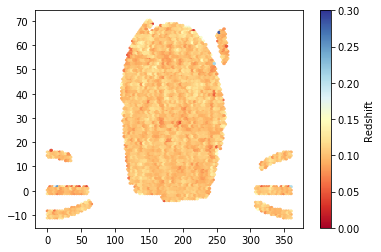

In [21]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')
hb = ax.hexbin(cast['ra'], cast['dec'], C=cast['z'], cmap=cm, 
               vmin=0, vmax=0.3)
cb = plt.colorbar(hb)
cb.set_label('Redshift')

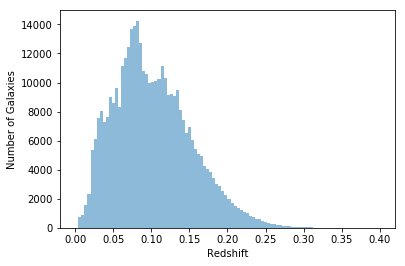

In [22]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(cast['z'], bins=100, range=(0, 0.4), alpha=0.5)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')

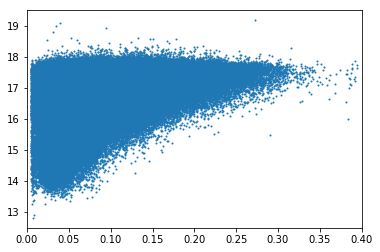

In [23]:
fig, ax = plt.subplots()
ax.scatter(cast['z'], rfit['m_tot'], s=1)
ax.set_xlim((0, 0.4))
ax.margins(0.05)

In [24]:
labels = ['r (AB mag)', 'g - r', 'Sersic n', 'Half-light Radius (arcsec)']
data = np.array([ rfit['m_tot'], gfit['m_tot'] - rfit['m_tot'], rfit['n_disk'], rfit['r_disk'] ]).T
data.shape

(385191, 4)

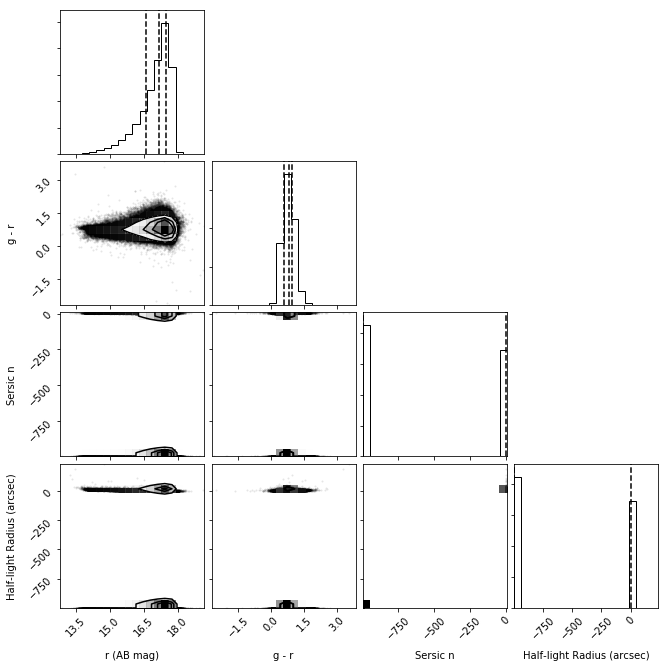

In [25]:
_ = corner(data, quantiles=[0.25, 0.50, 0.75], labels=labels)